In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!pip install tensorflow_addons

In [28]:
# Import libraries
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0, ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [29]:

# Define dataset paths
train_dir = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_1_Original/train'
val_dir = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_1_Original/val'
test_dir = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_1_Original/test'


# Define batch size
batch_size = 20
IMAGE_SIZE = (240, 240)
SEED = 42

# Create datasets using image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=SEED,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=True,  # to introduce randomness in each epoch and improve training.
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=SEED,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False,  # to maintain the original order for consistent evaluation.
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=SEED,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False,  # to maintain the original order for consistent evaluation.
)


class_index_to_label = {i: label for i, label in enumerate(train_ds.class_names)}
print('Class index number mapping to class folder names: ',class_index_to_label)
# class_weights_train = get_class_weights(train_ds)
# print('Class weights (train dataset): ', class_weights_train)

# Apply preprocessing
def preprocess_image(image, label):
#     image = tfa.image.gaussian_filter2d(image, (3, 3), 1.0)
    image = tfa.image.equalize(image)
    return image, label


train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=200)
val_ds = val_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)


# Optimize data loading (optional)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 5778 files belonging to 5 classes.
Found 826 files belonging to 5 classes.
Found 1656 files belonging to 5 classes.
Class index number mapping to class folder names:  {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


In [30]:
base_model = tf.keras.applications.convnext.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
x = base_model.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(612, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(210, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = True

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [31]:
# # Import libraries
# import math
# import sklearn
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# N_EPOCHS = 30
# warm_up_ep  = 4
# num_cycles  = 0.4
# lr_max = 1e-3

# def learning_rate_fn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
#     if current_step < num_warmup_steps:
#         # exponiancial warmup
#         return lr_max * 2 ** -(num_warmup_steps - current_step)
#     else:
#         progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
#         return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max


# def plot_lr_schedule(lr_schedule, epochs):
#     fig = plt.figure(figsize=(20, 10))
#     plt.plot([None] + lr_schedule + [None])
#     x = np.arange(1, epochs + 1)
#     x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
#     plt.xlim([1, epochs])
#     plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

#     plt.ylim([0, max(lr_schedule) * 1.1])

#     schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
#     plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

#     for x, val in enumerate(lr_schedule):
#         if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
#             if x < len(lr_schedule) - 1:
#                 if lr_schedule[x - 1] < val:
#                     ha = 'right'
#                 else:
#                     ha = 'left'
#             elif x == 0:
#                 ha = 'right'
#             else:
#                 ha = 'left'
#             plt.plot(x + 1, val, 'o', color='black');
#             offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
#             plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

#     plt.xlabel('Epoch', size=16, labelpad=5)
#     plt.ylabel('Learning Rate', size=16, labelpad=5)
#     plt.grid()
#     plt.show()




# LR_SCHEDULE = [learning_rate_fn(step, num_warmup_steps=warm_up_ep, lr_max=lr_max, num_cycles=num_cycles, num_training_steps=N_EPOCHS) for step in range(N_EPOCHS)]
# print('List of learning rate: ', LR_SCHEDULE)

# plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)



In [ ]:
#LR_SCHEDULE

In [33]:
# trained_model = tf.keras.models.load_model('/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_1_original_without_classweights.h5')

In [35]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_1_original_without_classweights2.h5', monitor='val_accuracy', mode='max', save_best_only=True),
    #tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_1_original_with_classweights_logs', histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),  # Stop training if no improvement after 7 epochs
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001),  # Reduce learning rate if no improvement after 2 epochs
    #tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0),
]


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)


history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[my_callbacks],
)

Epoch 1/30
289/289 [==============================] - ETA: 0s - loss: 22.1469 - accuracy: 0.3034

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


289/289 [==============================] - 169s 376ms/step - loss: 22.1469 - accuracy: 0.3034 - val_loss: 21.5870 - val_accuracy: 0.4116
Epoch 2/30
289/289 [==============================] - 108s 357ms/step - loss: 21.2211 - accuracy: 0.4393 - val_loss: 20.7155 - val_accuracy: 0.4782
Epoch 3/30
289/289 [==============================] - 107s 353ms/step - loss: 20.3608 - accuracy: 0.5017 - val_loss: 19.8771 - val_accuracy: 0.5605
Epoch 4/30
289/289 [==============================] - 111s 360ms/step - loss: 19.5513 - accuracy: 0.5599 - val_loss: 19.1531 - val_accuracy: 0.5823
Epoch 5/30
289/289 [==============================] - 107s 355ms/step - loss: 18.7500 - accuracy: 0.6194 - val_loss: 18.3542 - val_accuracy: 0.6114
Epoch 6/30
289/289 [==============================] - 106s 353ms/step - loss: 17.9845 - accuracy: 0.6620 - val_loss: 17.7171 - val_accuracy: 0.6489
Epoch 7/30
289/289 [==============================] - 96s 313ms/step - loss: 17.2313 - accuracy: 0.7077 - val_loss: 17.0659

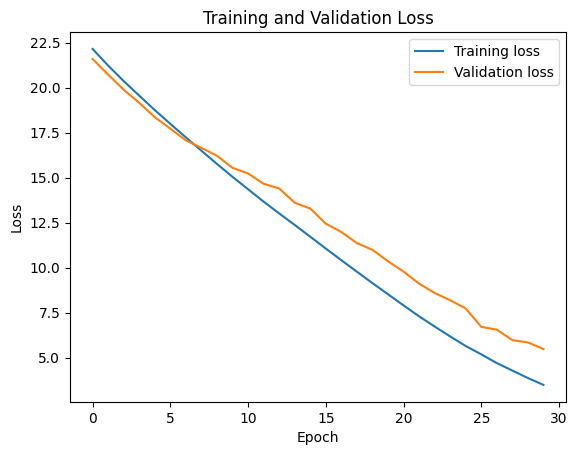

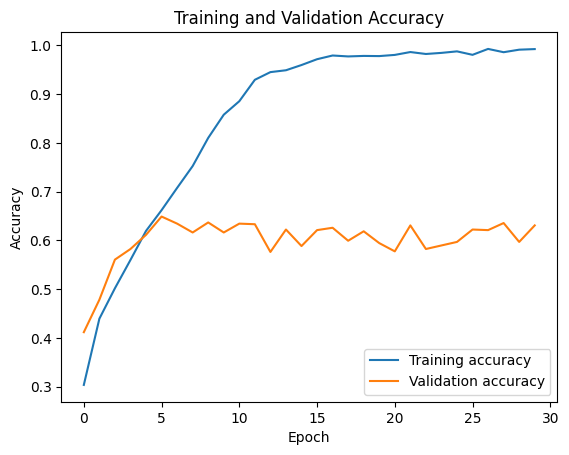

In [36]:
import matplotlib.pyplot as plt

# Plot the training and validation loss curves
plt.plot(model.history.history['loss'], label='Training loss')
plt.plot(model.history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(model.history.history['accuracy'], label='Training accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


42/42 [==============================] - 8s 103ms/step


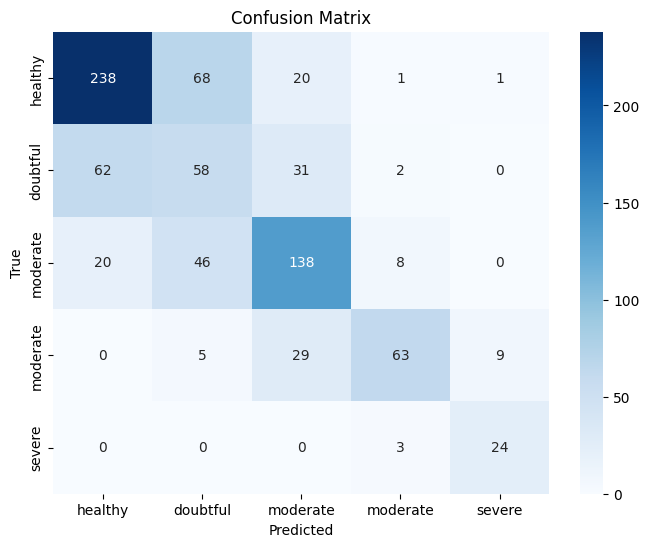

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_pred = model.predict(val_ds)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for x, y in val_ds])
y_true_labels = np.argmax(y_true, axis=1)

# Compute the confusion matrix
confusion = confusion_matrix(y_true_labels, y_pred_labels)

class_names = ['healthy', 'doubtful', 'moderate', 'moderate', 'severe']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
